## Tunability

Tunability measures the influence of hyperparameters on algorithms in various ways (see https://arxiv.org/pdf/2406.17523). Here we'll use grid to get a few insights into our target problems using the HyperGrid sweeper.

In [122]:
# First let's load the example data
import pandas as pd

runhistory = pd.read_csv("example_grids/branin/runhistory.csv")
runhistory

,config_id,budget,performance,x0,x1
0,0,20,308.129096,-5.0,0.0
1,1,20,161.255497,-5.0,5.0
2,2,20,64.381898,-5.0,10.0
3,3,20,17.508300,-5.0,15.0
4,4,20,55.602113,0.0,0.0
5,5,20,20.602113,0.0,5.0
6,6,20,35.602113,0.0,10.0
7,7,20,100.602113,0.0,15.0
8,8,20,14.341398,5.0,0.0
9,9,20,26.622743,5.0,5.0


In [123]:
# Let's check which values we have per hyperparameter
runhistory["x0"].unique(), runhistory["x1"].unique()

(array([-5.,  0.,  5., 10.]), array([ 0.,  5., 10., 15.]))

In [124]:
# The first metric to look at is the overall tunability which is the difference between a default performance (here we choose median) and the best performance
import numpy as np

def get_overall_tunability(runhistory, maximize=False):
    """Calculates the overall tunability of an algorithm"""
    median_performance = runhistory["performance"].median()
    if maximize:
        best_performance = runhistory["performance"].max()
    else:
        best_performance = runhistory["performance"].min()
    return median_performance - best_performance

print(f"Tunability is {np.round(get_overall_tunability(runhistory), decimals=2)}. This is the improvement we achieve by tuning the hyperparameters in our runs.")

Tunability is 47.32. This is the improvement we achieve by tuning the hyperparameters in our runs.


In [125]:
# Let's look at individual hyperparameters next
def get_hp_tunability(runhistory, hp_names, maximize=False):
    """Calculates the tunability of a hyperparameter"""
    median_performance = runhistory["performance"].median()
    median_config = runhistory[runhistory["performance"] > runhistory["performance"].median()].iloc[0]
    non_stationary_keys = ["performance", "budget", "config_id"] + hp_names
    defaults_except_for_nonstationary = runhistory.copy()
    for c in runhistory.columns:
        if c not in non_stationary_keys:
            defaults_except_for_nonstationary = defaults_except_for_nonstationary[defaults_except_for_nonstationary[c] == median_config[c]]
    if maximize:
        best_performance = defaults_except_for_nonstationary["performance"].max()
    else:
        best_performance = defaults_except_for_nonstationary["performance"].min()
    return median_performance - best_performance

print(f"Tunability of x0 is {np.round(get_hp_tunability(runhistory, ['x0']), decimals=2)}. This is the improvement we achieve by tuning only x0 of the median configuration in our runs.")
print(f"Tunability of x1 is {np.round(get_hp_tunability(runhistory, ['x1']), decimals=2)}. This is the improvement we achieve by tuning only x0 of the median configuration in our runs.")

# We can also do this for multiple hyperparameters at the same time
print(f"Joint tunability of x0 and x1 is {np.round(get_hp_tunability(runhistory, ['x0', 'x1']), decimals=2)}. This is the improvement we achieve by tuning only x0 and x1 of the median configuration in our runs.")
print("For Branin, this matches the overall tunability as there are only two hyperparameters.")

Tunability of x0 is 42.29. This is the improvement we achieve by tuning only x0 of the median configuration in our runs.
Tunability of x1 is 35.74. This is the improvement we achieve by tuning only x0 of the median configuration in our runs.
Joint tunability of x0 and x1 is 47.32. This is the improvement we achieve by tuning only x0 and x1 of the median configuration in our runs.
For Branin, this matches the overall tunability as there are only two hyperparameters.


In [126]:
# We can also do this for problem variations
def get_problem_tunability(runhistory, problem_name, problem_key, maximize=False):
    """Calculates the tunability of a problem variation"""
    median_performance = runhistory["performance"].median()
    if maximize:
        best_problem_performance = runhistory[runhistory[problem_key] == problem_name]["performance"].max()
    else:
        best_problem_performance = runhistory[runhistory[problem_key] == problem_name]["performance"].min()
    return median_performance - best_problem_performance

# For this to work we need to add a variation to our current runhistory which will just be synthetic data
# In practice you can load a second runhistory with different variations and concatenate them
runhistory["variation"] = "standard_branin"
alternate_history = runhistory.copy()
alternate_history["variation"] = "random_numbers"
alternate_history["performance"] = np.random.rand(len(alternate_history))
altered_history = pd.concat([runhistory, alternate_history])

print(f"Tunability of standard Branin is {np.round(get_problem_tunability(altered_history, 'standard_branin', 'variation'), decimals=2)}. This is the improvement we achieve by tuning on Branin specifically and not across multiple domains.")

Tunability of standard Branin is -2.47. This is the improvement we achieve by tuning on Branin specifically and not across multiple domains.


In [127]:
# Lastly, let's take a look at the THC score
def get_ptp(data, hp_name, hp_value, problem_key, maximize=False):
    """Calculates the PTP value."""
    data["rank"] = data.groupby(problem_key)["performance"].rank(ascending=maximize)
    value_ranks = data[data[hp_name] == hp_value]["rank"]
    ptp = value_ranks.max() - value_ranks.min()
    return ptp

def get_thc(runhistory, hp_name, problem_key, maximize=False):
    """Calculates the THC score of a configuration"""
    median_config = runhistory[runhistory["performance"] > runhistory["performance"].median()].iloc[0]
    non_stationary_keys = ["performance", "budget", "config_id"] + [hp_name, problem_key]
    defaults_except_for_nonstationary = runhistory.copy()
    for c in runhistory.columns:
        if c not in non_stationary_keys:
            defaults_except_for_nonstationary = defaults_except_for_nonstationary[defaults_except_for_nonstationary[c] == median_config[c]]

    num_values = defaults_except_for_nonstationary[hp_name].nunique()
    ptps = [get_ptp(defaults_except_for_nonstationary, hp_name, v, problem_key, maximize) for v in defaults_except_for_nonstationary[hp_name].unique()]
    normed_ptpt = [ptp / (num_values - 1) for ptp in ptps]
    return np.mean(normed_ptpt)

print(f"THC score of x0 is {np.round(get_thc(altered_history, 'x0', 'variation'), decimals=2)}. This quantifies the consistency of x0 across our two settings.")
print(f"THC score of x1 is {np.round(get_thc(altered_history, 'x1', 'variation'), decimals=2)}. This quantifies the consistency of x1 across our two settings.")

THC score of x0 is 0.33. This quantifies the consistency of x0 across our two settings.
THC score of x1 is 0.33. This quantifies the consistency of x1 across our two settings.


In [128]:
# We can do the same thing for our MLP data
runhistory = pd.read_csv("example_grids/mlp/runhistory.csv")

print(f"Tunability is {np.round(get_overall_tunability(runhistory), decimals=2)}. This is the improvement we achieve by tuning the hyperparameters in our runs.")


Tunability is 0.83. This is the improvement we achieve by tuning the hyperparameters in our runs.


Tunability of the learning_rate is -0.07. This is the improvement we achieve by tuning only the learning_rate of the median configuration in our runs.
Tunability of the batch_size is -0.07. This is the improvement we achieve by tuning only the batch_size of the median configuration in our runs.
Tunability of the solver is -0.05. This is the improvement we achieve by tuning only the solver of the median configuration in our runs.
Tunability of the activation is 0.07. This is the improvement we achieve by tuning only the activation of the median configuration in our runs.
Tunability of the n_layer is 0.37. This is the improvement we achieve by tuning only the n_layer of the median configuration in our runs.
Tunability of the n_neurons is -0.05. This is the improvement we achieve by tuning only the n_neurons of the median configuration in our runs.
Tunability of the learning_rate_init is -0.07. This is the improvement we achieve by tuning only the learning_rate_init of the median configur

<Axes: >

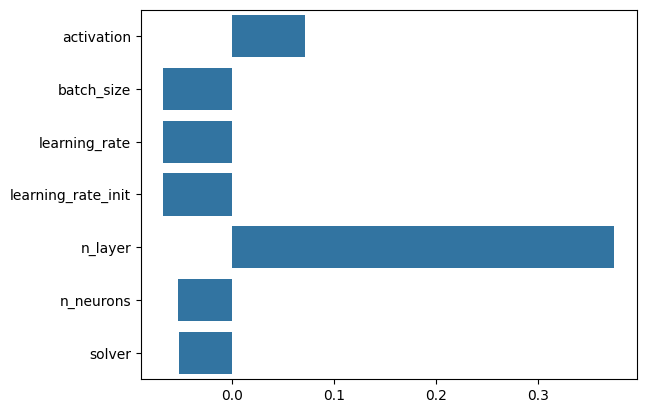

In [129]:
# Now single hyperparameters
print(f"Tunability of the learning_rate is {np.round(get_hp_tunability(runhistory, ['learning_rate']), decimals=2)}. This is the improvement we achieve by tuning only the learning_rate of the median configuration in our runs.")
print(f"Tunability of the batch_size is {np.round(get_hp_tunability(runhistory, ['batch_size']), decimals=2)}. This is the improvement we achieve by tuning only the batch_size of the median configuration in our runs.")
print(f"Tunability of the solver is {np.round(get_hp_tunability(runhistory, ['solver']), decimals=2)}. This is the improvement we achieve by tuning only the solver of the median configuration in our runs.")
print(f"Tunability of the activation is {np.round(get_hp_tunability(runhistory, ['activation']), decimals=2)}. This is the improvement we achieve by tuning only the activation of the median configuration in our runs.")
print(f"Tunability of the n_layer is {np.round(get_hp_tunability(runhistory, ['n_layer']), decimals=2)}. This is the improvement we achieve by tuning only the n_layer of the median configuration in our runs.")
print(f"Tunability of the n_neurons is {np.round(get_hp_tunability(runhistory, ['n_neurons']), decimals=2)}. This is the improvement we achieve by tuning only the n_neurons of the median configuration in our runs.")
print(f"Tunability of the learning_rate_init is {np.round(get_hp_tunability(runhistory, ['learning_rate_init']), decimals=2)}. This is the improvement we achieve by tuning only the learning_rate_init of the median configuration in our runs.")

#Actually this would be better as a plot
import seaborn as sns
import matplotlib.pyplot as plt
tunabilities = [get_hp_tunability(runhistory, [hp]) for hp in runhistory.columns if hp not in ["performance", "budget", "config_id"]]
sns.barplot(x=tunabilities, y=[hp for hp in runhistory.columns if hp not in ["performance", "budget", "config_id"]])

Joint tunability of the learning_rate, solver, and batch_size is -0.05. This is the improvement we achieve by tuning only the learning_rate, solver and batch_size of the median configuration in our runs.
Joint tunability of n_layer, n_neurons, and activation is 0.79. This is the improvement we achieve by tuning only n_layer, n_neurons, and activation of the median configuration in our runs.


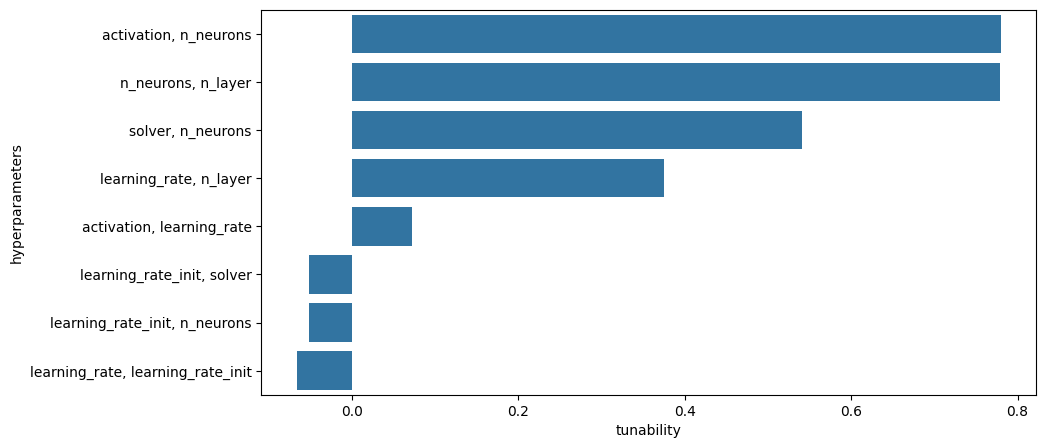

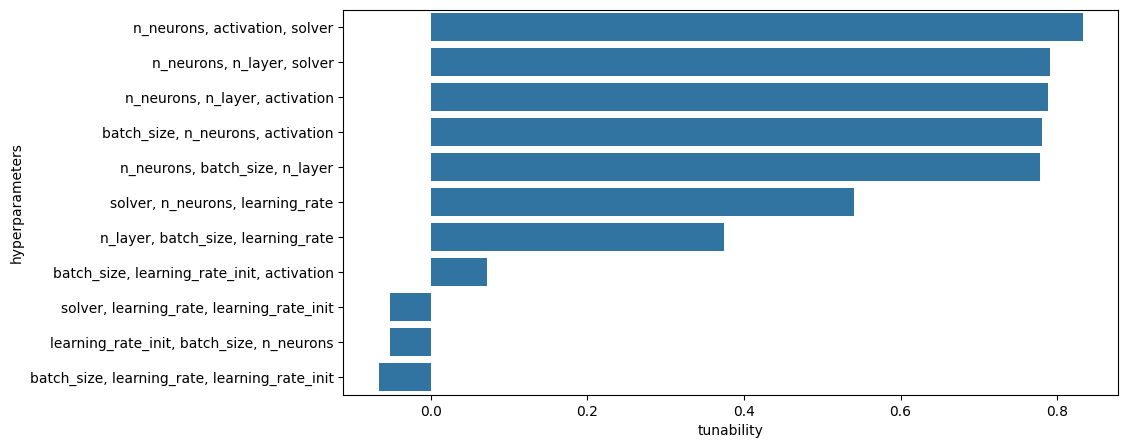

In [138]:
# And a few combinations
print(f"Joint tunability of the learning_rate, solver, and batch_size is {np.round(get_hp_tunability(runhistory, ['learning_rate', 'batch_size', 'solver']), decimals=2)}. This is the improvement we achieve by tuning only the learning_rate, solver and batch_size of the median configuration in our runs.")
print(f"Joint tunability of n_layer, n_neurons, and activation is {np.round(get_hp_tunability(runhistory, ['n_layer', 'n_neurons', 'activation']), decimals=2)}. This is the improvement we achieve by tuning only n_layer, n_neurons, and activation of the median configuration in our runs.")

# Let's plot these with depth 2 and 3
combinations_2_hps = [(hp1, hp2) for hp1 in runhistory.columns if hp1 not in ["performance", "budget", "config_id"] for hp2 in runhistory.columns if hp2 not in ["performance", "budget", "config_id"] and hp2 != hp1]
tunabilities_2_hps = [get_hp_tunability(runhistory, [hp1, hp2]) for hp1, hp2 in combinations_2_hps]
df = pd.DataFrame({"tunability": tunabilities_2_hps, "hyperparameters": [f"{hp1}, {hp2}" for hp1, hp2 in combinations_2_hps]})
df = df.sort_values(by="tunability", ascending=False)
df.drop_duplicates(subset="tunability", inplace=True)
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df, x="tunability", y="hyperparameters")

combinations_3_hps = [(hp1, hp2, hp3) for hp1 in runhistory.columns if hp1 not in ["performance", "budget", "config_id"] for hp2 in runhistory.columns if hp2 not in ["performance", "budget", "config_id"] and hp2 != hp1 for hp3 in runhistory.columns if hp3 not in ["performance", "budget", "config_id"] and hp3 != hp1 and hp3 != hp2]
tunabilities_3_hps = [get_hp_tunability(runhistory, [hp1, hp2, hp3]) for hp1, hp2, hp3 in combinations_3_hps]
df = pd.DataFrame({"tunability": tunabilities_3_hps, "hyperparameters": [f"{hp1}, {hp2}, {hp3}" for hp1, hp2, hp3 in combinations_3_hps]})
df = df.sort_values(by="tunability", ascending=False)
df.drop_duplicates(subset="tunability", inplace=True)
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df, x="tunability", y="hyperparameters")